In [5]:
from make_dataset import creat_dataframe, seperate_data
import polars as pl
from typing import Generator, List, Tuple, Iterator
import numpy.typing as npt

from torch_geometric.data import HeteroData
import torch
import numpy as np

import re

In [6]:
df = creat_dataframe(1000)

In [7]:
p_df, winner_df = seperate_data(df)

In [8]:
winner_df

winner_blue,winner_red
f32,f32
1.0,0.0
0.0,1.0
0.0,1.0
1.0,0.0
0.0,1.0
1.0,0.0
1.0,0.0
0.0,1.0
0.0,1.0


In [9]:
blue = p_df.select(pl.col("^blue.*$"))
red = p_df.select(pl.col("^red.*$"))

In [10]:
b_cols = set([x.replace('red_', '') for x in blue.columns])

In [11]:
r_cols = set([x.replace('blue_', '') for x in red.columns])

In [12]:
# a_cols.difference(b_cols)

In [13]:
# b_cols.difference(a_cols)

In [14]:
columns = " ".join(p_df.columns)
column_groups = list(set(re.findall(r"\s?[a-z]+_([a-z]+)", columns)))

In [15]:
column_groups

['items',
 'general',
 'gold',
 'summoners',
 'keystone',
 'role',
 'champion',
 'level']

In [16]:
blue_nodes_dfs = [blue.select(pl.col(f"^.*{x}.*$")) for x in column_groups]

In [17]:
def name_generator(n:str) -> Generator:
    count = 1
    while True:
        yield f"player_{count}_{n}"
        count += 1

In [18]:
blue_player_feature_vals = [x.transpose(column_names=name_generator(column_groups[n])) for n,x in enumerate(blue_nodes_dfs)]

In [19]:
def get_matchup_node_features(df: pl.DataFrame) -> Tuple[pl.DataFrame,...]:
  feature_df = pl.DataFrame()

  columns = " ".join(p_df.columns)
  # columns = list(set(re.findall(r"\s?([a-z]+_[a-z]+)", columns)))
  columns = list(set(re.findall(r"(\w+_\w*)_\w+", columns)))
  print(columns)

  _df = (df
    .lazy()
    .with_columns(
      [
        (pl.concat_list(pl.col(f"^{x}.*$")).alias(x)) for x in columns
      ]
    )
    .select([pl.col(pl.List(pl.Float32)), pl.col("^.*gold$"), pl.col("^.*level$")])
    .collect()
  )


  p1_df = _df.select(pl.col(f"^blue.*$"))
  p2_df = _df.select(pl.col(f"^red.*$"))

  p1_df.columns = list(map(lambda x: x.removeprefix("blue_"), p1_df.columns)) 
  p2_df.columns = list(map(lambda x: x.removeprefix("red_"), p2_df.columns)) 
  

  return p1_df, p2_df

In [20]:
p1, p2 = get_matchup_node_features(p_df)

['blue_keystone', 'red_items', 'blue_items', 'blue_general', 'red_summoners', 'blue_champion', 'red_keystone', 'red_general', 'blue_summoners', 'red_champion']


In [21]:
p2.head()

items,summoners,keystone,champion,gold,level
list[f32],list[f32],list[f32],list[f32],f32,f32
"[1.0, 1.0, ... 0.0]","[1.0, 1.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.108401,0.294118
"[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.078591,0.294118
"[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.154472,0.411765
"[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.140921,0.411765
"[1.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.197019,0.470588


In [22]:
p1.head()

keystone,items,champion,summoners,gold,level
list[f32],list[f32],list[f32],list[f32],f32,f32
"[1.0, 0.0]","[1.0, 1.0, ... 0.0]","[0.0, 0.0, ... 0.0]","[1.0, 1.0, ... 0.0]",0.078591,0.294118
"[1.0, 0.0]","[1.0, 0.0, ... 0.0]","[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]",0.108401,0.294118
"[1.0, 0.0]","[0.0, 1.0, ... 0.0]","[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]",0.140921,0.411765
"[1.0, 0.0]","[0.0, 1.0, ... 0.0]","[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]",0.154472,0.411765
"[1.0, 0.0]","[1.0, 1.0, ... 0.0]","[0.0, 0.0, ... 0.0]","[0.0, 0.0, ... 0.0]",0.121951,0.411765


In [23]:
ps = p1.vstack(p2.select(p1.columns), in_place=False)

In [24]:
p2.head()

items,summoners,keystone,champion,gold,level
list[f32],list[f32],list[f32],list[f32],f32,f32
"[1.0, 1.0, ... 0.0]","[1.0, 1.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.108401,0.294118
"[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.078591,0.294118
"[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.154472,0.411765
"[0.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.140921,0.411765
"[1.0, 0.0, ... 0.0]","[1.0, 0.0, ... 0.0]","[1.0, 0.0]","[0.0, 0.0, ... 0.0]",0.197019,0.470588


In [25]:
ps_dict = ps.to_dict(as_series=False)

In [94]:
from torch_geometric.data.storage import NodeStorage, EdgeStorage

In [27]:
ps_dict_t = {k: NodeStorage(x =torch.tensor(v)) for k, v in ps_dict.items()}

In [99]:
hetero_graph = HeteroData()
hetero_graph.update(ps_dict_t) 

In [129]:
hetero_graph['player'].x = torch.ones(1000, 1)
hetero_graph['player'].y = torch.tensor(winner_df['winner_blue'].to_numpy())
hetero_graph['winner'].x = torch.ones(1000, 1)

In [130]:
hetero_graph

HeteroData(
  keystone={ x=[2000, 2] },
  items={ x=[2000, 164] },
  champion={ x=[2000, 143] },
  summoners={ x=[2000, 9] },
  gold={ x=[2000] },
  level={ x=[2000] },
  (keystone, edge, keystone)={ edge_index=[2, 2000] },
  (keystone, edge, items)={ edge_index=[2, 2000] },
  (keystone, edge, champion)={ edge_index=[2, 2000] },
  (keystone, edge, summoners)={ edge_index=[2, 2000] },
  (keystone, edge, gold)={ edge_index=[2, 2000] },
  (keystone, edge, level)={ edge_index=[2, 2000] },
  (player, edge, keystone)={ edge_index=[2, 2000] },
  (keystone, edge, player)={ edge_index=[2, 2000] },
  (items, edge, keystone)={ edge_index=[2, 2000] },
  (items, edge, items)={ edge_index=[2, 2000] },
  (items, edge, champion)={ edge_index=[2, 2000] },
  (items, edge, summoners)={ edge_index=[2, 2000] },
  (items, edge, gold)={ edge_index=[2, 2000] },
  (items, edge, level)={ edge_index=[2, 2000] },
  (player, edge, items)={ edge_index=[2, 2000] },
  (items, edge, player)={ edge_index=[2, 2000] },
 

In [131]:
half_edges = torch.vstack([torch.arange(0, ps.shape[0]//2), torch.arange(ps.shape[0] //2) + 1000])

In [132]:
# all_nodes = torch.arange(0, ps.shape[0])
# hetero_graph['chmapion', 'edge', 'champion'] = torch.cat([half_edges, half_edges.flip(dims=(0,))], dim=1)

In [133]:
for d in ps.columns:
  for r in ps.columns:

    hetero_graph[d, r].edge_index =  torch.cat([half_edges, half_edges.flip(dims=(0,))], dim=1)
  
  hetero_graph['player', d].edge_index = torch.cat([half_edges, half_edges], dim=1)
  hetero_graph[d, 'player'].edge_index = torch.cat([half_edges, half_edges], dim=1)

hetero_graph['player', 'winner'].edge_index = torch.tensor(np.where(winner_df['winner_blue'] == 1)[0]).repeat(2, 1)


In [136]:
hetero_graph.num_classes

AttributeError: 'HeteroData' has no attribute 'num_classes'

### Old stuff for homogeneous graph

In [18]:
node_features_p1 = torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in p1_dict[0].values()], batch_first=True)

node_features_p2 = torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in p1_dict[1].values()], batch_first=True)

In [19]:
node_features_p1.shape

torch.Size([6, 149])

In [66]:
nodes = torch.cat([node_features_p2, node_features_p1])

In [47]:
# !pip install line_profiler
# %load_ext line_profiler

In [48]:
# %lprun -f get_matchup_node_features get_matchup_node_features(p_df)

In [49]:
donor_edge = torch.hstack([torch.tile(torch.arange(0, 10), dims=(1, 10)), torch.tile(torch.arange(10, 20), dims=(1, 10))])

In [50]:
reciever_edge = torch.hstack([torch.repeat_interleave(torch.arange(10, 20), 10), torch.repeat_interleave(torch.arange(0, 10), 10)])

In [51]:
donor_edge

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,
          6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,
          4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
          0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13,
         14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11,
         12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]])

In [52]:
reciever_edge

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9])

In [64]:
g_edges = torch.vstack([donor_edge, reciever_edge])
g_edges

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,
          6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,
          4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
          0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13,
         14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11,
         12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
         1

In [68]:
torch.cat([g_edges, ])

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,
          6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,
          4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
          0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13,
         14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11,
         12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
         1

In [574]:
nodes = torch.ones((20, 1))

In [575]:
from torch_geometric.data import Data

In [576]:
graph = Data(x=nodes, edge_index=g_edges)

In [577]:
graph.is_undirected()

True

In [589]:
import torch_geometric.utils.convert as convert
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

In [586]:
G = convert.to_networkx(graph)

In [588]:
bipartite.is_bipartite(G)

True

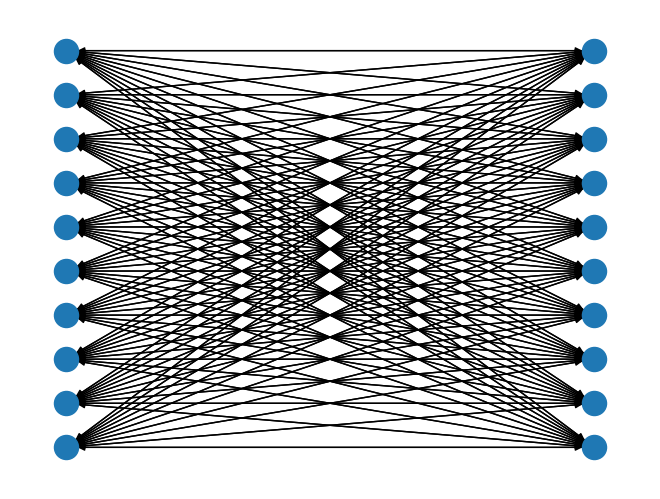

In [590]:
X, Y = bipartite.sets(G)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(G, pos=pos)
plt.show()